# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run camera server on the camera computer (192.168.0.10, use vnc viewer)
```bash
python stream_server.py --ip='192.168.0.10' # camera pc ip
```

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = False
ENABLE_DETECT = True

CONNECT_INDY = False
CONNECT_MOBILE = False

VISUALIZE = True
PLANNING_MULTIPROC = True

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.32, 0.08]
# TOOL_OFFSET = 0.01
TOOL_OFFSET = 0.1
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

IP_CUR = "192.168.0.40"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.0.40
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

from utils.streaming import *
from utils.detection_util import *

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 8, -7, 7, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, 
# face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, 
                       tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer, WayFramer
brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE,0,0), 
    rpy=(0,np.pi/2*1,0))

# waypoint
WP_DIMS = (0.6,0.4,WALL_THICKNESS)
gscene.create_safe(
    gtype=GEOTYPE.BOX, name="wayframer", link_name=HOLD_LINK,
    dims=WP_DIMS, center=(0,0,WP_DIMS[2]/2), rpy=(0,0,0), 
    color=(1, 0, 0, 0.5), display=True,
    collision=False, fixed=True)
wayframer = pscene.create_binder(
    bname="wayframer", gname="wayframer", _type=WayFramer, 
    point=(0,0,-WP_DIMS[2]/2-CLEARANCE), rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]

connection command:
kmb0: True
indy1: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/jhkim/.local/lib/python2.7/site-packages/dash/dash.py", line 1716, in run_server
    self.server.run(host=host, port=port, debug=debug, **flask_run_options)
  File "/home/jhkim/.local/lib/python2.7/site-packages/flask/app.py", line 990, in run
    run_simple(host, port, self, **options)
  File "/home/jhkim/.local/lib/python2.7/site-packages/werkzeug/serving.py", line 1052, in run_simple
    inner()
  File "/home/jhkim/.local/lib/python2.7/site-packages/werkzeug/serving.py", line 1005, in inner
    fd=fd,
  File "/home/jhkim/.local/lib/python2.7/site-packages/werkzeug/serving.py", line 848, in make_server
    host, port, app, request_handler, passthrough_errors, ssl_context, fd=fd
  File "/home/jhkim/.local/lib/pyth

#### 0.1.2 Load saved environment map

In [3]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR)
# kmm.update_map()
kmm.load_map()
pt_list = kmm.convert_im2scene(kmm.cost_canny, gscene, MOBILE_BASE, height=0.2)
_ = kmm.add_to_scene(gscene, pt_list, gtype=GEOTYPE.BOX, radius=kmm.resolution/2)
# plt.figure(figsize=(20, 10))
# plt.subplot(1,2,1)
# plt.imshow(kmm.cost_im)
# plt.subplot(1,2,2)
# plt.imshow(kmm.cost_canny)

## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

#### 1.1.1 Move to bed-seek pose 

In [4]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

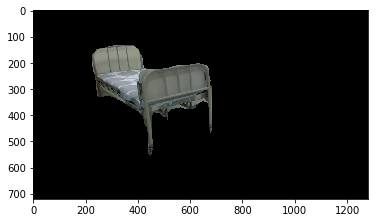

In [5]:
if ENABLE_DETECT:
    attacth_to_server()
if CONNECT_CAM:
    rdict = stream_capture_image(
        ImageType.FirstView, obj_type="bed", host=CAM_HOST)
else:
    rdict = load_rdict("bed")
    
cdp = rdict2cdp(rdict)
    
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while ENABLE_DETECT:
    # Take a picture again after rotate
    if CONNECT_CAM:
        time.sleep(1)
        rdict = stream_capture_image(
            ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    
    # Output of inference(mask for detected table)
    mask_out = detect_from_server(rdict['color'])
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    if CONNECT_INDY:
        with indy:
            turn_dir *= -1
            dQ = np.add(dQ, [5,0,0,0,0,0])
            Qto = Q0+turn_dir*dQ
            Qto[0] = (Qto[0]+180/2)%180-180/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = np.deg2rad(indy.get_joint_pos())

#### 1.1.2  detect bed and add to the scene

In [22]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)
if ENABLE_DETECT:
    icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed.STL', 
                       Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))
    # Try ICP1
    if np.any(mask_out):
        pcd = icp_bed.add_image(cdp_masked, Tc=None)

        Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.7,0,-0.6)))
        Tbs1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=VISUALIZE)
        Tbs2, fitness2 = icp_bed.compute_ICP(None, thres=0.15, visualize=VISUALIZE)
        
    # Better result is adopted
    T_co_bed = Tbs1 if fitness1 > fitness2 else Tbs2
    T_bo_bed = np.matmul(T_bc, T_co_bed)

    bed_center = T_bo_bed[:3,3]
    bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
    COLOR_BED_COL = (0,1,0,0.3)
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    if Rot_rpy(bed_rpy)[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)
    if VISUALIZE: # show final result
        icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed_vis"].get_tf(VIEW_POSE_EXT)))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    COLOR_BED_COL = (0,1,0,0.3)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

bed_vis = gscene.NAME_DICT["bed_vis"]

Apply point-to-point ICP
registration::RegistrationResult with fitness=7.161985e-01, inlier_rmse=6.887131e-02, and correspondence_set size of 53543
Access transformation to get result.
Transformation is:
[[ 0.82171422 -0.02736778  0.56924226 -1.81132488]
 [-0.23651014 -0.92514654  0.296929   -0.05285455]
 [ 0.51850622 -0.37862235 -0.76667882  4.32868179]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.300.
Apply point-to-point ICP
registration::RegistrationResult with fitness=6.853531e-01, inlier_rmse=7.604181e-02, and correspondence_set size of 51237
Access transformation to get result.
Transformation is:
[[-0.80578757  0.18138563  0.56374254 -1.20535445]
 [ 0.35925081  0.90649343  0.22182991 -1.40359561]
 [-0.47079215  0.

In [49]:
FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=(0,0,0))
o3d.visualization.draw_geometries([pcd, FOR_origin])
pcd.points

std::vector<Eigen::Vector3d> with 74760 elements.
Use numpy.asarray() to access data.

In [85]:
# front ICP
if ENABLE_DETECT:  
     if np.any(mask_out):
        pcd_bed = pcd.voxel_down_sample(0.01)
#         pcd_bed_c = np.matmul(SE3_inv(Tbc)[:3,:3], pcd_bed.T).T + SE3_inv(Tbc)[:3,3]
        pcd_bed.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.02, max_nn=30))
        point_normals = np.asarray(pcd_bed.normals)

        print(len(point_normals))
        view_vec = (0,0,1)
        
        idx = []
        for i in range(len(point_normals)):
            if np.dot(view_vec, point_normals[i])<0:
                idx.append(i)
        
        print(len(idx))
        pts = np.zeros((len(idx),3))
        for i in range(len(idx)):
            pts[i] = pcd_bed.points[idx[i]]
        
        front_pcd = o3d.geometry.PointCloud()
        front_pcd.points = o3d.utility.Vector3dVector(pts)
        icp_bed.pcd = front_pcd
        
        o3d.visualization.draw_geometries([front_pcd])
#         T_bo = bed_vis.get_tf(VIEW_POSE_EXT)
#         T_guess = np.matmul(T_cb, T_bo)
#         Tbs_f, fitness_f = icp_bed.compute_ICP(To=T_guess, thres=0.15, visualize=True)

#         T_bo_bed = np.matmul(T_bc, Tbs_f)
#         bed_center = T_bo_bed[:3,3]
#         bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
#         COLOR_BED_COL = (0,1,0,0.3)
#         T_bo_new = align_z(T_bo_bed)
#         bed_rpy = Rot2rpy(T_bo_new[:3,:3])

#         # adjust
#         bed_center[2]=0
#         if Rot_rpy(bed_rpy)[0,0] > 0:
#             bed_rpy[2] += np.pi
#         move_bed(gscene, bed_center, bed_rpy)

18180
7287


In [83]:
# front ICP - distance cut
if ENABLE_DETECT:  
     if np.any(mask_out):
        max_dist = np.linalg.norm(pcd.get_center()) * 0.95
        max_z = pcd.get_center()[2]
        
        pcd_bed = np.asarray(pcd.points)
        print(len(pcd_bed))
        idx = []
        for i in range(len(pcd_bed)):
#             if pcd_bed[i,2] < max_z:
#                 idx.append(i)
            if np.linalg.norm(pcd_bed[i]) < max_dist:
                idx.append(i)
        
        print(len(idx))
        pts = np.zeros((len(idx),3))
        for i in range(len(idx)):
            pts[i] = pcd_bed[idx[i]]
        
        front_pcd = o3d.geometry.PointCloud()
        front_pcd.points = o3d.utility.Vector3dVector(pts)
        icp_bed.pcd = front_pcd
        
        o3d.visualization.draw_geometries([front_pcd, FOR_origin])
        T_bo = bed_vis.get_tf(VIEW_POSE_EXT)
        T_guess = np.matmul(T_cb, T_bo)
        Tbs_f, fitness_f = icp_bed.compute_ICP(To=T_guess, thres=0.1, visualize=True)

        T_bo_bed = np.matmul(T_bc, Tbs_f)
        bed_center = T_bo_bed[:3,3]
        bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
        COLOR_BED_COL = (0,1,0,0.3)
        T_bo_new = align_z(T_bo_bed)
        bed_rpy = Rot2rpy(T_bo_new[:3,:3])

        # adjust
        bed_center[2]=0
        if Rot_rpy(bed_rpy)[0,0] > 0:
            bed_rpy[2] += np.pi
        move_bed(gscene, bed_center, bed_rpy)

74760
47973
Apply point-to-point ICP
registration::RegistrationResult with fitness=3.238229e-01, inlier_rmse=3.564401e-02, and correspondence_set size of 24209
Access transformation to get result.
Transformation is:
[[ 0.80839469 -0.00617124  0.58860845 -1.80827423]
 [-0.18373093 -0.95263336  0.24234816  0.06834166]
 [ 0.55923246 -0.30405855 -0.77123759  4.26495464]
 [ 0.          0.          0.          1.        ]]


### 1.2 Detect Closet

#### 1.2.0 set checker

In [8]:
wp_task, wp_hdl = add_waypoint_task(
    pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
    parent="floor_ws", color=(0, 0, 1, 0.5))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)

#### 1.2.1  move to full view position

##### calc fule view pose

In [9]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -80., 0])
# VIEW_MOVED = np.deg2rad([  0., -10.,  -0.,  -0.,  -100., 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_DETECT:
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_ref = 150
elif CLOSET_LOCATION == "RIGHT":       
    angle_ref = -150
    
bed_dim = np.linalg.norm(bed_mat.dims)
h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3 
while True:
    angle_view = angle_ref + np.random.uniform(-10, 10)
    dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/8
    Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
    Tbs = np.matmul(Tbs, 
                    SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
    Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                    SE3(np.identity(3), (-dist_view, 0,0)))
    Tbc = np.matmul(Tbs, Tsc)
    Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
    Tmc[:3,:3] = np.identity(3)
    Tbm = np.matmul(Tbc, SE3_inv(Tmc))
    full_view_ext = np.copy(VIEW_POSE_EXT)
    full_view_ext[:2] = Tbm[:2,3]
    full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
    gscene.show_pose(full_view_ext)
    ccheck.clear()
    res = ccheck(T_loal=Tbm, 
                 Q_dict=list2dict(full_view_ext, gscene.joint_names))
    if res:
        VIEW_MOVED_EXT = full_view_ext
        break
        
kmm.set_collision(False)

CLOSET on LEFT


##### move to full view pose

In [10]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))

In [11]:
kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)

#### 1.2.2 redetect bed

Apply point-to-point ICP
registration::RegistrationResult with fitness=8.445661e-01, inlier_rmse=6.946023e-02, and correspondence_set size of 72506
Access transformation to get result.
Transformation is:
[[ 0.5218138  -0.04521666 -0.85186019  4.08606448]
 [-0.8494454   0.06428054 -0.5237466   1.59710977]
 [ 0.0784401   0.99690695 -0.00486661 -0.03894417]
 [ 0.          0.          0.          1.        ]]


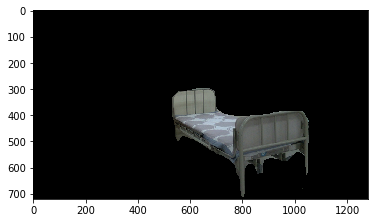

In [12]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
# capture image of full view
if CONNECT_CAM:
    rdict = stream_capture_image(
        ImageType.FullView, obj_type="full_view", host=CAM_HOST)
    
else:
    rdict = load_rdict("full_view")
    
cdp = rdict2cdp(rdict)
# Output of inference(mask for detected table)
mask_out = detect_from_server(cdp.color)

if np.any(mask_out):
    cdp_masked = apply_mask(cdp, mask_out)
    plt.imshow(cdp_masked.color[:,:,[2,1,0]])

    if ENABLE_DETECT:
        icp_bed.clear()
        pcd = icp_bed.add_image(cdp_masked, Tc=T_bc)
        T_bs_pre = gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT)
        T_bo_bed, fitness = icp_bed.compute_ICP(To=T_bs_pre, thres=0.15, visualize=VISUALIZE)
        #adjust
        T_bo_bed[2]=0
        T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
        move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))
        
        if VISUALIZE: # show final result
            icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT)))
else:
    raise(RuntimeError("bed not detected"))

#### 1.2.3  detect and add closet

In [13]:
VISUALIZE = False
if ENABLE_DETECT:
    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
    
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, obj_type="top_table", host=CAM_HOST)
    else:
        rdict = load_rdict("top_table")

    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    
    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)
    
    
    pcd_masked = mask_boxes(pcd_closet, 
                        boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                        Q=VIEW_MOVED_EXT, inside=True, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked = mask_boxes(pcd_masked, 
                        boxes=[gscene.NAME_DICT["bed_box"], 
                               gscene.NAME_DICT["bed_wall"], 
                               gscene.NAME_DICT["floor_box"]], 
                        Q=VIEW_MOVED_EXT, inside=False, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
    icp_closet.add_pointcloud(pcd_masked, T_bc)
    
    Tbs = bed_vis.get_tf(VIEW_MOVED_EXT)
    initial_guess = icp_closet.get_initial_by_median(Tbs[:3, :3], (0.3,0.2,-1))
    T_bo, fitness = icp_closet.compute_ICP(initial_guess, thres=0.15, visualize=VISUALIZE)
    
    #adjust
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))
#     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
#     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))
    
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

Apply point-to-point ICP
registration::RegistrationResult with fitness=3.641812e-01, inlier_rmse=7.384910e-02, and correspondence_set size of 19444
Access transformation to get result.
Transformation is:
[[-8.62839170e-01 -2.09100339e-02 -5.05045873e-01  4.07015636e+00]
 [-5.05472347e-01  3.07432889e-02  8.62294934e-01  1.72481260e+00]
 [-2.50384514e-03  9.99308571e-01 -3.70959578e-02  1.72406894e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]



## 2. Closet cleaning

### 2.1. Make closet cleaning plan

In [14]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [15]:
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
                                  rpy=(0,0,0))

def make_plan_fun(surface, Q_CUR, tip_dir, tool_dir, plane_val, xout_cut=False):
    ccheck.clear()
    div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                            get_division_dict(surface, brush_face, robot_config, 
                                              plane_val=plane_val, tip_dir=tip_dir, TOOL_DIM=TOOL_DIM, 
                                              ccheck=ccheck, resolution=0.02, xout_cut=xout_cut)

    HOME_POSE_MOVE = np.copy(Q_CUR[6:])
    test_fun = TestBaseDivFunc(ppline, floor_ws, surface, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=tool_dir,
                                  multiprocess=PLANNING_MULTIPROC, 
                                  timeout=0.3, timeout_loop=3)
    test_fun.clear()

    idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
        div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
        test_fun=test_fun, lazy_base_thresh=np.max(TOOL_DIM)/2)

    snode_schedule_list, idx_bases, idc_divs, scene_args_list, scene_kwargs_list = refine_order_plan(
        ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
        floor_ws, wayframer, surface, Tsm_keys, surface_div_centers,  
        WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
    test_fun.clear()
    if len(snode_schedule_list)>0:
        Q_CUR = snode_schedule_list[-1][-1].state.Q
    return snode_schedule_list, scene_args_list, scene_kwargs_list, Q_CUR, test_fun

In [16]:
snode_schedule_list_leftup, scene_args_list_leftup, scene_kwargs_list_leftup, Q_CUR, test_fun= \
    make_plan_fun(closet_leftup, Q_CUR, "up", 1, plane_val=None)
snode_schedule_list_rightup, scene_args_list_rightup, scene_kwargs_list_rightup, Q_CUR, test_fun = \
    make_plan_fun(closet_rightup, Q_CUR, "up", 1, plane_val=None)
snode_schedule_list_down, scene_args_list_down, scene_kwargs_list_down, Q_CUR, test_fun = \
    make_plan_fun(closet_down, Q_CUR, "down", -1, plane_val=None)
snode_schedule_list = snode_schedule_list_leftup + snode_schedule_list_rightup + snode_schedule_list_down
scene_args_list = scene_args_list_leftup + scene_args_list_rightup + scene_args_list_down
scene_kwargs_list = scene_kwargs_list_leftup + scene_kwargs_list_rightup + scene_kwargs_list_down

terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
======================= terminated 27: max iteration time reached (3/3 s) ===============================
======================= terminated 28: max iteration time reached (3/3 s) ===============================
======================= terminated 3: max iteration time reached (3/3 s) ===============================
======================= terminated 14: max iteration time reached (3/3 s) ===============================
======================= terminated 5: max iteration time reached (3/3 s) ===============================
======================= terminated 31: max iteration time reached (3/3 s) ===============================
======================= terminated 4: max iteration time reached (3/3 s) ===============================
======================= terminated 1: max iteration time reached (3/3 s) ===============================
======================= terminated 19: max iteration time reached (3/3 s) ======

======================= terminated 18: max iteration time reached (3/3 s) ===============================
======================= terminated 21: max iteration time reached (3/3 s) ===============================
======================= terminated 24: max iteration time reached (3/3 s) ===============================
======================= terminated 15: max iteration time reached (3/3 s) ===============================
======================= terminated 9: max iteration time reached (3/3 s) ===============================
======================= terminated 33: max iteration time reached (3/3 s) ===============================
======================= terminated 10: max iteration time reached (3/3 s) ===============================
======================= terminated 20: max iteration time reached (3/3 s) ===============================
======================= terminated 11: max iteration time reached (3/3 s) ===============================
terminate_on_first is deprecated. Use max_solut

======================= terminated 14: max iteration time reached (3/3 s) ===============================
======================= terminated 2: max iteration time reached (3/3 s) ===============================
======================= terminated 15: max iteration time reached (3/3 s) ===============================
======================= terminated 16: max iteration time reached (3/3 s) ===============================
======================= terminated 33: max iteration time reached (3/3 s) ===============================
======================= terminated 6: max iteration time reached (3/3 s) ===============================
======================= terminated 4: max iteration time reached (3/3 s) ===============================
======================= terminated 22: max iteration time reached (3/3 s) ===============================
======================= terminated 0: max iteration time reached (3/3 s) ===============================
======================= terminated 11: max iterati

======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 20: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 8: required answers acquired from other agent =======

Goal reached
======================= terminated 0: required answers acquired ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired from other agent ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 10: required answers acquired ===============================
======================= terminated 3: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
======================= terminated 32: required answers acquired from other agent =======================

======================= terminated 31: required answers acquired from other agent ===============================
======================= terminated 24: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 14: required answers acquired ===============================
======================= terminated 22: required answers acquired ===============================
======================= terminated 5: required answers acquired from other agent ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
======================= terminated 28: required answers acquired from other agent =======================

======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
======================= terminated 22: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent ===============================
======================= terminated 31: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 21: required answers acquired from other agent ========

======================= terminated 9: required answers acquired from other agent ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
Goal reached
Goal reached
======================= terminated 14: required answers acquired ===============================
======================= terminated 11: required answers acquired ===============================
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ==============================

======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 1: required answers acquired ===============================
======================= terminated 16: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 6: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ==============

======================= terminated 8: required answers acquired ===============================
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired from other agent ===============================
======================= terminated 12: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================

Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 13: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 4: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 15: required answers acquired from other agent ===============================
======================= terminated 18: required answers acquired from other agent 

======================= terminated 28: required answers acquired ===============================
Goal reached
======================= terminated 24: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
======================= terminated 16: required answers acquired from other agent ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 17: required answers acquired from other agent ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
Goal rea

Goal reached
======================= terminated 15: required answers acquired ===============================
======================= terminated 33: required answers acquired from other agent ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
Goal reached
======================= terminated 21: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
Goal reached
======================= terminated 1: required answers acquired ===============================
Goal reached
======================= terminated 31: required answers acquired ===============================
Goal reached
======================= terminated 4: required answers acquired ===============================
Goal reac

======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 3: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 20: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 5: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ========

======================= terminated 26: required answers acquired ===============================
Goal reached
======================= terminated 27: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 6: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
update 1th motion
Goal reached
update 1th motion
Goal reached
update 1th motion
Goal reached
no skip 0: 0.1199
Try mix
can skip 1: 0.0012
skip success


### 2.2. Execute closet cleaning sequence

In [17]:
adjust_list = []
VISUALIZE = True
def adjust_base_on(Qref, closet_gtem):
    traj, succ = get_look_motion(mplan, ROBOT_NAME, Qref, 
                                 target_point=closet_gtem,
                                 com_link = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][-1],
                                 view_dir = [0,0,1],timeout = 1)
    traj_rev = np.array(list(reversed(traj)))

    if not succ:
        traj = [Qref, Qref]
        traj_rev = [Qref, Qref]

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

        time.sleep(1)

    if ENABLE_DETECT:
        icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                           Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

        if CONNECT_CAM:
            rdict = stream_capture_image(ImageType.FirstView, obj_type="closet", host=CAM_HOST)
        else:
            rdict = load_rdict("closet")

        T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet_vis"].get_tf(Qref)

        cdp = rdict2cdp(rdict)
        pcd_closet = cdp2pcd(cdp, T_bc)


        pcd_masked = mask_boxes(pcd_closet, 
                            boxes=[gscene.NAME_DICT["closet_box"]], 
                            Q=Qref, inside=True, 
                            merge_rule=np.all, link_ref="base_link")
        pcd_masked = mask_boxes(pcd_masked, 
                            boxes=[gscene.NAME_DICT["bed_box"], 
    #                                        gscene.NAME_DICT["bed_wall"], 
                                   gscene.NAME_DICT["floor_box"]], 
                            Q=Qref, inside=False, 
                            merge_rule=np.all, link_ref="base_link")
        pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
        icp_closet.add_pointcloud(pcd_masked, T_bc)

    #     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
    #     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))

        initial_guess = gscene.NAME_DICT["closet_vis"].get_tf(Qref)
        T_bo_close, fitness = icp_closet.compute_ICP(initial_guess, thres=0.15, visualize=VISUALIZE)

        # calculate transform based on obtained points
        pcd_center_prev = pcd_masked.get_center()
        pcd_center_transformed_prev = np.matmul(T_bc[:3,:3], pcd_center_prev).transpose() + T_bc[:3,3]

        T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_transformed_prev)
        T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
        T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
        T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
        T_bo_c_fix[2,3] = 0

        # get Twoff from redetection
        Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix

        Tbw0 = wayframer.get_tf_handle(Qref)
        Tow = np.matmul(SE3_inv(Tbo0), Tbw0)
        Tbw1 = np.matmul(Tbo1, Tow)

        Qtar = np.copy(Qref)
        Qtar[:2] = Tbw1[:2,3]
        Qtar[2] = Rot2axis(Tbw1[:3,:3], 3)

        adjust_list.append((kmb.get_qcur(), Qref, Qtar))

        kmb.joint_move_make_sure(Qtar[:6])

    if CONNECT_INDY:
        with indy: # retrieve motion
            crob.move_joint_traj(traj_rev, one_by_one=True)
        
class SwitchState(Enum):
    NONE = 0
    BASE_MOVED = 1
    SWEEP_APPROACH = 2
    SWEEP_RETRACT = 3
    SWEEPING = 4

class ModeSwitcherKMB:
    def __init__(self, pscene, gtem_ref, push_dist=0.05):
        self.pscene = pscene
        self.crob = pscene.combined_robot
        self.push_dist = push_dist
        self.pushed_before = False
        self.gtem_ref = gtem_ref

    def switch_in(self, snode_pre, snode_new):
        switch_state = SwitchState.NONE
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_new.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        if len(subjects) == 2: # skip base move case - do nothing
            switch_state = SwitchState.NONE
        if len(subjects) ==0: # joint motion: quit sweep and homing - retract before motion
            if self.pushed_before and self.push_dist > 1e-6:
                switch_state = SwitchState.SWEEP_RETRACT
                from_Q = kmb.get_qcur()
                Tbm = gscene.get_tf(MOBILE_BASE, from_Q)
                Tbm2 = np.matmul(Tbm, SE3(np.identity(3), 
                                          (-self.push_dist, 0, 0)))
                Qto = np.copy(from_Q[:6])
                Qto[:2] = Tbm2[:2,3]
                print("retract")
                kmb.joint_move_make_sure(Qto)
                self.pushed_before = False
        elif subjects[0] == "sweep": # sweep approach or sweeping
            i_swp = pscene.subject_name_list.index("sweep")
            if snode_pre.state.node[i_swp] == 0: # sweep approach - move forward after motoin
                if not self.pushed_before:
                    switch_state = SwitchState.SWEEP_APPROACH
                else:
                    switch_state = SwitchState.NONE
            else: # sweeping
#                 indy.collision_policy = POLICY_NO_COLLISION_DETECTION
                switch_state = SwitchState.SWEEPING
        elif subjects[0] == "waypoints":
            switch_state = SwitchState.BASE_MOVED
        return switch_state

    def switch_out(self, switch_state, snode_new):
        kmb = self.crob.robot_dict['kmb0']
        if switch_state == SwitchState.BASE_MOVED:
            print("adjust")
            adjust_base_on(snode_new.state.Q, self.gtem_ref)
        elif switch_state == SwitchState.SWEEP_APPROACH: # move forward
            if not self.pushed_before and self.push_dist > 1e-6:
                print("push forward")
                from_Q = kmb.get_qcur()
                Tbm = gscene.get_tf(MOBILE_BASE, from_Q)
                Tbm2 = np.matmul(Tbm, SE3(np.identity(3), 
                                          (self.push_dist, 0, 0)))
                Qto = np.copy(from_Q[:6])
                Qto[:2] = Tbm2[:2,3]
                kmb.joint_move_make_sure(Qto)
                self.pushed_before = True
        elif switch_state == SwitchState.SWEEPING:
            pass
#             indy.collision_policy = POLICY_KEEP_PAUSE
                
mode_switcher=ModeSwitcherKMB(pscene, closet_leftup)

In [18]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

In [19]:
swp_fin_list = []
mode_switcher.push_dist = 0.11

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
#     mode_switcher.gtem_ref = \
#         gscene.NAME_DICT[pscene.subject_dict['sweep'].geometry.parent]
    if CONNECT_INDY and CONNECT_MOBILE:
        ppline.execute_schedule(snode_schedule, one_by_one=True, 
                                mode_switcher=mode_switcher)
    else:
        ppline.play_schedule(snode_schedule)
        
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 2
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
motions: 2
(0, 0)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 2
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
motions: 2
(0, 0)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)


### 2.3. Clear highlight

In [20]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.remove_subject(pscene.subject_dict["sweep"])
for child in copy.copy(closet_leftup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_rightup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_down.children):
    gscene.remove(gscene.NAME_DICT[child])

## 3. Bed cleaning

### 3.1 Make bed cleaning plan

#### 3.1.1 make plan

In [21]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

BED_OFFSET = 0.01
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

snode_schedule_list, scene_args_list, scene_kwargs_list, Q_CUR, test_fun = \
    make_plan_fun(bed_mat, Q_CUR, "front", 1, EE_HEIGHT, xout_cut=True)

('Height Reference: ', 0.6619999895095825)
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
Goal reached
======================= terminated 13: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 29: required answers acquired from other agent ===============================
======================= terminated 0: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 9: required answers acquired from other agent ===============================
Goal reached
======================= terminated 7: required answers acquired ===============================
Goal reached
======================= terminated 11: required answers acquired ========

======================= terminated 23: required answers acquired from other agent ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 32: required answers acquired ===============================
======================= terminated 21: required answers acquired ===============================
======================= terminated 22: required answers acquired from other agent ===============================
Goal reached
======================= terminated 2: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 35: required answers acquired ===============================
Goal reached
======================= terminated 31: required answers acquired ===============================
===

======================= terminated 3: required answers acquired ===============================
Goal reached
======================= terminated 12: required answers acquired ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
======================= terminated 8: required answers acquired from other agent ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
======================= terminated 11: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 23: required answers acquired ===============================
====

======================= terminated 35: required answers acquired from other agent ===============================
======================= terminated 19: required answers acquired from other agent ===============================
======================= terminated 26: required answers acquired from other agent ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 23: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired from other agent ===============================
======================= terminated 20: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ======

======================= terminated 9: required answers acquired from other agent ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 2: required answers acquired ===============================
Goal reached
======================= terminated 17: required answers acquired ===============================
Goal reached
======================= terminated 18: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 25: required answers acquired ===============================
Goal reached
======================= terminated 31: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
================

======================= terminated 13: required answers acquired ===============================
======================= terminated 8: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired from other agent ===============================
======================= terminated 35: required answers acquired from other agent ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 16: required answers acquired ===============================
Goal reached
======================= terminated 20: required answers acquired ===============================
======================= terminated 34: required answers acquired from other agent ===============================
Goal reac

======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
Goal reached
======================= terminated 6: required answers acquired ===============================
Goal reached
======================= terminated 9: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired ===============================
Goal reached
======================= terminated 11: required answers acquired ===============================
======================= terminated 4: required answers acquired from other agent ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 19: required answers acquired ============

Goal reached
======================= terminated 32: required answers acquired ===============================
Goal reached
======================= terminated 33: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 7: required answers acquired ===============================
======================= terminated 25: required answers acquired ===============================
Goal reached
======================= terminated 34: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
Goal reached
======================= terminated 2: required answers acquired ===============================
======================= terminated 4: required answers acquired ===============================
======================= terminated 18: required answers acquired from other agent ===============================
======================= termin

======================= terminated 25: required answers acquired from other agent ===============================
======================= terminated 27: required answers acquired from other agent ===============================
======================= terminated 28: required answers acquired from other agent ===============================
Goal reached
======================= terminated 14: required answers acquired ===============================
Goal reached
======================= terminated 13: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 19: required answers acquired ===============================
======================= terminated 9: required answers acquired ===============================
Goal reached
======================= terminated 10: required answers acquired ===============================
======================= terminated 30: required answers acquired from other agent ===========================

======================= terminated 31: required answers acquired from other agent ===============================
======================= terminated 14: required answers acquired from other agent ===============================
======================= terminated 32: required answers acquired from other agent ===============================
======================= terminated 2: required answers acquired from other agent ===============================
Goal reached
======================= terminated 24: required answers acquired from other agent ===============================
======================= terminated 11: required answers acquired ===============================
======================= terminated 33: required answers acquired from other agent ===============================
======================= terminated 34: required answers acquired from other agent ===============================
======================= terminated 25: required answers acquired from other agent ===========

======================= terminated 17: required answers acquired from other agent ===============================
Goal reached
======================= terminated 19: required answers acquired ===============================
Goal reached
======================= terminated 23: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Use 36/36 agents
Goal reached
Goal reached
Goal reached
======================= terminated 16: required answers acquired from other agent ===============================
======================= terminated 7: required answers acquired ===============================
======================= terminated 8: required answers acquired ===============================
======================= terminated 32: required answers acquired from other agent ===============================
Goal reached
======================= terminated 18: required answers acquired from other agent ===============================
Goal

Goal reached
Goal reached
======================= terminated 19: required answers acquired ===============================
======================= terminated 4: required answers acquired ===============================
Goal reached
Goal reached
======================= terminated 21: required answers acquired ===============================
======================= terminated 30: required answers acquired from other agent ===============================
======================= terminated 20: required answers acquired ===============================
Goal reached
======================= terminated 22: required answers acquired ===============================
======================= terminated 14: required answers acquired from other agent ===============================
Goal reached
======================= terminated 5: required answers acquired ===============================
Goal reached
======================= terminated 15: required answers acquired from other agent ===================

### 3.3 Execute bed cleaning sequence

In [22]:
swp_fin_list = []
mode_switcher.push_dist = 0
mode_switcher.gtem_ref = closet_leftup

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    if CONNECT_INDY and CONNECT_MOBILE:
        ppline.execute_schedule(snode_schedule, one_by_one=True, 
                                mode_switcher=mode_switcher)
    else:
        ppline.play_schedule(snode_schedule)
        
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 3
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)
motions: 2
(0, 0)->(0, 1)
(0, 1)->(1, 1)
(1, 1)->(2, 1)
motions: 2
(0, 0)->(1, 1)
(1, 1)->(2, 1)
(2, 1)->(2, 1)


### 3.4 Clear highlight

In [38]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.remove_subject(pscene.subject_dict["sweep"])
for child in copy.copy(bed_mat.children):
    gscene.remove(gscene.NAME_DICT[child])

In [25]:
# save_pickle("adjust_list.pkl", adjust_list)
# save_pickle("gtem_args.pkl", gscene.get_gtem_args())
# save_pickle("Q_all.pkl", [[snode.state.Q for snode in snode_schedule] for snode_schedule in snode_schedule_list])

## Load exp dat

In [11]:
adjust_list = load_pickle("adjust_list.pkl")
gtem_args = load_pickle("gtem_args.pkl")
Q_all = load_pickle("Q_all.pkl")

In [39]:
for garg in gtem_args:
    if garg['parent'] == None and garg['link_name']=="base_link":
        if garg["name"] in gscene.NAME_DICT:
            gscene.NAME_DICT[garg["name"]].set_offset_tf(center=garg["center"], orientation_mat=Rot_rpy(garg["rpy"]))
gscene.update_markers_all()        

In [ ]:
VISUALIZE = True
adjust_base_on(Q_all[4][0], closet_leftup)